# Microgrid performance simulation

Case of Microgrid project with *wind* and *solar* sources,
plus a *battery* and a *dispatchable generator*:

<img alt='schematic of a microgrid with wind and H2' src='./images/Microgrid_h2.png' style='height:18em'>

Demo of main data structures and functions of [Microgrids.jl](https://github.com/Microgrids-X/Microgrids.jl).
Main steps are:

1. Describe the Microgrid project and components (including loading time series data)
2. Simulation the Microgrid
3. Analyze simulation results (technical and economic)

After this demonstration, you can go to the next step: [Microgrid sizing optimization](Microgrid_sizing_optimization.ipynb)

In [7]:
using Microgrids
using Printf, CSV, DataFrames, Statistics

In [8]:
using PyPlot # For plotting only. Can be skipped or commented out
using PyCall
np=pyimport("numpy")

PyObject <module 'numpy' from 'C:\\Users\\nikiemaje\\.julia\\conda\\3\\x86_64\\lib\\site-packages\\numpy\\__init__.py'>

In [9]:
with_plots = isdefined(Main, :PyPlot)

true

## Load time series data

Read load and solar data:
- Load: real consumption data at an hourly timestep from the [Ushant island](https://en.wikipedia.org/wiki/Ushant) in 2016
- Solar and wind data comes from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html). See [data/SOURCES.md](data/SOURCES.md).

In [11]:
data = DataFrame(CSV.File("$(@__DIR__)/data/Ouessant_data_2016.csv"))

# Simulation steps
nsteps = length(data.Load)
@assert(nsteps == 8760) # 1 year at an hourly timestep

# Split load, solar and wind data:
Pload = data.Load # kW
Ppv1k =  data.Ppv1k ./ 1000; # convert to kW/kWp
wind_speed = data.Wind; # m/s

# Calibrate wind speed data against a mast measurement 
ws_gain = 1.059 # ratio of Mast's mean /PVGIS' mean
wind_speed = ws_gain*wind_speed

println("Time series statistics:")
@printf("- Load: min %.0f, mean %.0f, max %.0f kW\n",
        minimum(Pload), mean(Pload), maximum(Pload))
@printf("- PV capacity factor: %.2f %%\n", mean(Ppv1k)*100) # yearly capacity factor of 12% (quite low in 2016 in Ouessant)
@printf("- Wind speed: mean %.2f m/s\n", mean(wind_speed))

Time series statistics:
- Load: min 294, mean 773, max 1707 kW
- PV capacity factor: 11.83 %
- Wind speed: mean 8.03 m/s


In [12]:
Pload[1]

1453.0

Display load time series

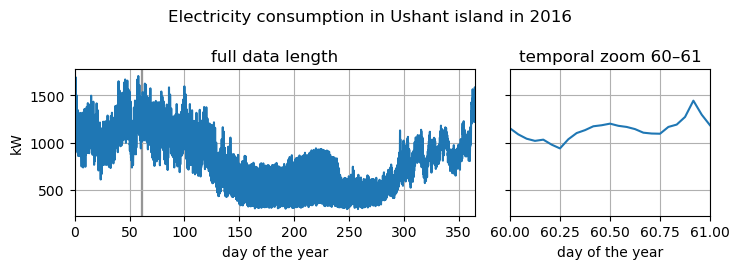

In [15]:
td = collect((0:nsteps-1)/24) # time in days
#tm = collect((0:nsteps-1)/730)
"""helper: plot time series with a temporal zoom"""
function plot_ts_zoom(t, ts; zoom, color::String, title::String, xlabel::String, ylabel::String)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7.5,2.7), sharey=true,
                                   gridspec_kw=Dict("width_ratios" => [2,1]))
    ax1.plot(t, ts, color=color)
    ax1.axvspan(zoom[1], zoom[2], color="k", alpha=0.3)
    ax2.plot(t, ts, color=color)
    ax2.set_xlim(zoom[1], zoom[2])

    ax1.grid(true)
    ax2.grid(true)
    fig.suptitle(title)
    ax1.set_xlim(t[1], t[end])
    ax1.set(
        title="full data length",
        xlabel=xlabel,
        ylabel=ylabel
    )
    ax2.set(
        title="temporal zoom $(zoom[1])–$(zoom[2])",
        xlabel=xlabel,
    )
    fig.tight_layout()
    return fig, (ax1, ax2)
end

if with_plots
    fig, (ax1, ax2) = plot_ts_zoom(
        td, Pload;
        zoom=(60,61), color="tab:blue",
        title="Electricity consumption in Ushant island in 2016",
        xlabel="day of the year", ylabel="kW"
    )
end;

### Generate wind power capacity factor time series from wind speed

We use the generic wind power curve model `capacity_from_wind` to transform wind speed time series into a capacity factor time series (normalized power).
The main parameters of this power curve are:
- Rotor swept area (m²), i.e. derived from the rotor diameter with $S=\pi(D/2)^2$
- Turbine Specific Power (W/m²), i.e. rated power compared to area

Wind turbine parameters used here are fitted to an [EWT 900 kW DW52](https://ewtdirectwind.com/products/dw52/):

In [19]:
S_D52 = pi * (52/2)^2 # rotor swept area m²
TSP_D52 = 900e3/S_D52 # W/m²
v_out = 25.0 # m/s
Cp_D52, α_D52 = 0.521, 3.1; # fitted from actual power curve

In [20]:
cf_wind = capacity_from_wind.(wind_speed; TSP=TSP_D52, Cp=Cp_D52, v_out=v_out, α=α_D52)
@printf("Wind power capacity factor: %.2f %%\n", mean(cf_wind)*100) # (pretty high in Ouessant)

Wind power capacity factor: 39.70 %


## Microgrid description

Describe the Microgrid project and its components using dedicated data structures

### Project parameters

Financial parameters like discount rate, as well as technical details like the timestep of input data.

In [23]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1. # h

project = Project(lifetime, discount_rate, timestep, "€")

Project(25, 0.05, 1.0, "€")

Parameters chosen to be common to all Components (but they could differ)

- replacement price relative to initial investment price
- salvage price relative to initial investment price

In [25]:
replacement_price_ratio = 1.0
salvage_price_ratio = 1.0;

Load default parameters

In [27]:
include("data/Microgrid_Wind-Solar-H2_data.jl"); 

Data definition for Microgrid with wind, solar and Hybrid Storage System...


### Dispatchable generator (Diesel)

Used as last recourse, when there is not enough production from renewables and the battery is empty (not used in this example)

In [30]:
gen = ProductionUnit(0.0,
      fuel_intercept, fuel_slope, fuel_price,
      capex_def[1], om_price_hour_gen, om_price_gen, lifetime_gen_y,lifetime_gen_h,lifetime_gen_starts,
      load_ratio_min_gen, replacement_price_ratio,
      salvage_price_ratio, input_unit_gen,output_unit_gen)


ProductionUnit{Float64}(0.0, 0.0, 0.24, 1.0, 400.0, 0.02, 0.0, 25.0, 15000.0, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")

### fuel tank 

In [32]:
ftank = Tank(capacity_rated_ftank,capex_def[2], om_price_ftank,lifetime_ftank,loss_factor_ftank,0.0,
          fuel_min_ratio, fuel_max_ratio,fuel_price, replacement_price_ratio, salvage_price_ratio)

Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0)

### Fuel cell 

In [35]:
fuel_cell = ProductionUnit(1800.,cons_intercept_fc, cons_rate_fc,cons_price_fc,capex_def[3], om_price_hour_fc, om_price_fc,lifetime_fc_y,lifetime_fc_h,lifetime_fc_starts,
              load_min_ratio_fc,replacement_price_ratio, salvage_price_ratio,input_unit_fc,output_unit_fc)





ProductionUnit{Float64}(1800.0, 0.0, 0.0625, 0.0, 1600.0, 0.0, 45.0, 15.0, 45000.0, 5000.0, 0.05, 1.0, 1.0, "Kg", "KWh")

### H2 Tank

In [37]:
hytank = Tank(12000.,capex_def[4], om_price_hytank,lifetime_hytank,loss_factor_hytank,0.5,
              LoH_min_ratio, LoH_max_ratio,hy_price,replacement_price_ratio, salvage_price_ratio)


Tank{Float64}(12000.0, 500.0, 4.0, 25.0, 0.0, 0.5, 0.0, 1.0, 14.0, 1.0, 1.0)

###  Dispatchable Compound 

In [39]:
dispatchables = DispatchableCompound{Float64}([gen,], [fuel_cell])

DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(0.0, 0.0, 0.24, 1.0, 400.0, 0.02, 0.0, 25.0, 15000.0, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1800.0, 0.0, 0.0625, 0.0, 1600.0, 0.0, 45.0, 15.0, 45000.0, 5000.0, 0.05, 1.0, 1.0, "Kg", "KWh")])

### Tank compound 

In [41]:
tanks = TankCompound{Float64}(ftank,hytank)

TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(12000.0, 500.0, 4.0, 25.0, 0.0, 0.5, 0.0, 1.0, 14.0, 1.0, 1.0))

### Battery energy storage

Used as a buffer between the renewables production and the consumption

In [43]:
battery = Battery(5000.,
      capex_def[6], om_price_sto, lifetime_sto, lifetime_cycles,
      charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_max,0.0,
      replacement_price_ratio, salvage_price_ratio)

Battery{Float64}(5000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0)

### Electrolyzer
to convert renewable surproduction into hydrogen

In [45]:
elyz = ProductionUnit(2000.,cons_intercept_elyz,cons_rate_elyz,cons_price_elyz, capex_def[5], om_price_hour_elyz,om_price_elyz, lifetime_elyz_y,lifetime_elyz_h,lifetime_elyz_starts,
  load_min_ratio_elyz,replacement_price_ratio, salvage_price_ratio,input_unit_elyz,output_unit_elyz)


ProductionUnit{Float64}(2000.0, 0.0, 56.0, 0.0, 1600.0, 0.0, 44.0, 20.0, 45000.0, 5000.0, 0.05, 1.0, 1.0, "KWh", "Kg")

### Photovoltaic (PV) generation

Used in priority to feed the load (along wind power). PV generation is assumed proportional to the irradiance data load in previous section.

In [47]:
photovoltaic = Photovoltaic(power_rated_pv, irradiance,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)

Photovoltaic{Float64}(5000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0)

Display PV production time series (which is proportional to the rated power of the plant `power_rated_pv`)
- PV production is computed by calling the `production` method on the `Photovoltaic` instance

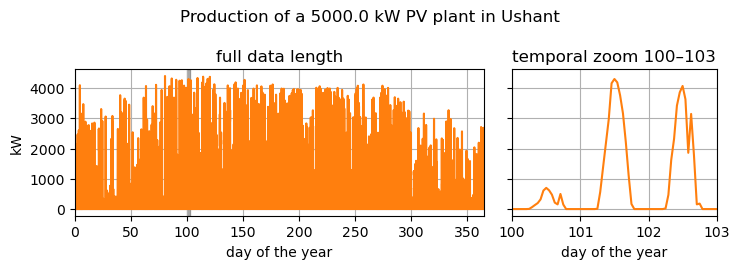

In [49]:
if with_plots
    fig, (ax1, ax2) = plot_ts_zoom(
        td, production(photovoltaic);
        zoom=(100,103), color="tab:orange",
        title="Production of a $power_rated_pv kW PV plant in Ushant",
        xlabel="day of the year", ylabel="kW"
    )
end;

### Wind power generation

Used in priority to feed the load along solar power.

The simple wind power model use the fixed capacity factor data derived from wind speed in the previous section.

In [51]:
windgen = WindPower(power_rated_wind, cf_wind,
    investment_price_wind, om_price_wind,
    lifetime_wind,
    replacement_price_ratio, salvage_price_ratio)

WindPower{Float64}(1800.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399, 0.037530379586714784, 0.03792477182913709, 0.037530379586714784, 0.03674751985711801], 3500.0, 100.0, 25.0, 1.0, 1.0)

Display wind power time series:
- Wind production is computed by calling the `production` method on the `WindPower` instance

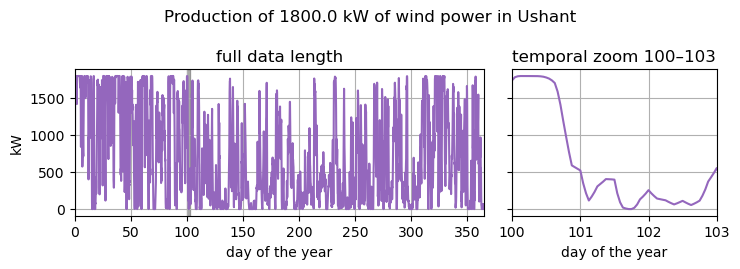

In [53]:
if with_plots
    fig, (ax1, ax2) = plot_ts_zoom(
        td, production(windgen);
        zoom=(100,103), color="tab:purple",
        title="Production of $power_rated_wind kW of wind power in Ushant",
        xlabel="day of the year", ylabel="kW"
    )
end;

### Microgrid data structure

the `Microgrid` data structure groups:
- project parameters
- load time series
- all components: energy storage systems, renewable power generators, 

In [55]:
microgrid = Microgrid(project, Pload,dispatchables,
    [elyz,],tanks,battery, [
        photovoltaic,
        windgen
    ]
)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(0.0, 0.0, 0.24, 1.0, 400.0, 0.02, 0.0, 25.0, 15000.0, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1800.0, 0.0, 0.0625, 0.0, 1600.0, 0.0, 45.0, 15.0, 45000.0, 5000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 56.0, 0.0, 1600.0, 0.0, 44.0, 20.0, 45000.0, 5000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0), Tank{Float64}(12000.0, 500.0, 4.0, 25.0, 0.0, 0.5, 0.0, 1.0, 14.0, 1.0, 1.0)), Battery{Float64}(5000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(5000.0, [0.0, 

## Simulate the microgrid

launched with the `simulate` method:

In [58]:
oper_traj, oper_stats, mg_costs = simulate(microgrid,dispatch_1);

In details, the simulation is done in two stages:

1. simulate the **operation**, in particular the energy flow at an hourly timestep between components: 
    - generates operation statistics as `OperationStats` data structure
    - records trajectories of operation variables
2. evaluate the **economic cost** of the project, based on its description and on the operation statistics: 
    - generates cost data as `MicrogridCosts` data structure

These successive stages can be run manually with their dedicated functions (see `simulate` code).

Microgrid simulation code is optimized to run in less than 1 ms:

(you can use [Benchmarktools](https://juliaci.github.io/BenchmarkTools.jl/)'s `@btime` for more accurate timing results)

In [63]:
using BenchmarkTools

In [64]:
@btime oper_traj = operation(microgrid,dispatch_1);

  439.800 μs (57 allocations: 1.21 MiB)


## Analyze Microgrid simulation results

### Technical performance

Operation statistics are in `oper_stats` (`OperationStats` data structure) with fields such as `renew_rate` (fraction of renewables in the energy mix), `shed_rate` (fraction of shed, i.e. unserved load)...

In [67]:
@printf("Load shedding rate: %.1f%%\n", oper_stats.shed_rate*100)
@printf("Renewable rate: %.1f%%\n", oper_stats.renew_rate*100)

Load shedding rate: 0.2%
Renewable rate: 100.0%


All available statistics:

In [70]:
oper_stats

OperationStats with fields:
- served_energy: 6.7622e6 kWh
- shed_energy: 12747.0 kWh
- shed_max: 1520.2 kW
- shed_hours: 10.0 h
- shed_duration_max: 6.0 h
- shed_rate: 0.0018814 in [0,1]
- gen_energy: 0.0 kWh
- gen_hours: 0.0 h
- gen_starts: 0.0 
- gen_fuel: 0.0 L
- gen_rt_at_nom: 0.0 h
- gen_min_rp: 0.0 KW
- gen_avg_rp: NaN kW
- gen_avg_rt: NaN h
- gen_max_rt: 0.0 h
- gen_min_rt: 8760.0 h
- gen_ru2: 0.0 
- gen_ro2: 0.0 
- fc_energy: 651690.0 kWh
- fc_hours: 1169.0 h
- fc_starts: 133.0 
- h2_consumed: 40730.0 kg
- fc_rt_at_nom: 0.0 h
- fc_min_rp: 90.0 KW
- fc_avg_rp: 557.47 kW
- fc_avg_rt: 8.7895 h
- fc_max_rt: 63.0 h
- fc_min_rt: 1.0 h
- fc_ru2: 6.0 
- fc_ro2: 127.0 
- h2_produced: 34730.0 kg
- elyz_hours: 2050.0 h
- elyz_starts: 161.0 
- elyz_consumed_energy: 1.9449e6 kWh
- elyz_rt_at_nom: 309.0 h
- elyz_min_rp: 100.45 KW
- elyz_avg_rp: 948.73 kW
- elyz_avg_rt: 12.733 h
- elyz_max_rt: 102.0 h
- elyz_min_rt: 1.0 h
- elyz_ru2: 15.0 
- elyz_ro2: 146.0 
- h2_chain_loss: 1.2936e6 kWh
- st

### Economic performance

Economic performance indicators are stored in `mg_costs` (as a `MicrogridCosts` data structure). This structure contains the following fields:
- two highlevel cost indicators: Net present Cost `npc` and Levelized Costs of Electricity `lcoe`
- a break down of cost factors for the entire project in `system`: initial investment, fuel... (as a `CostFactors` structure)
- a detailed break down of cost factors for each component in `generator`, `storage`, `nondispatchables[n]`... (also as `CostFactors` structures)

In [83]:
@printf("Levelized Cost of Electricity: %.3f \$/kWh\n", mg_costs.lcoe)
@printf("Net Present Cost: %.2f M\$ (over %d years at %.0f%% discount rate)\n",
    mg_costs.npc/1e6, project.lifetime, project.discount_rate*100)

Levelized Cost of Electricity: 0.380 $/kWh
Net Present Cost: 36.19 M$ (over 25 years at 5% discount rate)


Break down of cost factors for the entire project:

In [88]:
mg_costs.system

CostFactors(3.619206592391976e7, 2.6214e7, 3.4331555093547925e6, 7.709387677626477e6, 0.0, -1.1644772630615076e6)

Break down of cost factors for each nondispatchable power sources (i.e. renewables), in the same order as in `microgrid.nondispatchables`:

In [92]:
mg_costs.nondispatchables

2-element Vector{CostFactors}:
 CostFactors(7.409394456604475e6, 6.0e6, 0.0, 1.4093944566044747e6, 0.0, -0.0)
 CostFactors(8.836910021888055e6, 6.3e6, 0.0, 2.5369100218880544e6, 0.0, -0.0)

Definition of the fields of cost factors (`total` is the sum of all the other ones):

In [98]:
fieldnames(CostFactors)

(:total, :investment, :replacement, :om, :fuel, :salvage)

Remark 1: `npc` is equal to `system.total`

Remark 2: `CostFactors` structures like `mg_costs.system` support arithmetic operations (+,*,/) and rounding:

In [100]:
round(mg_costs.system/1e6; digits=2) # rounded costs in M$

CostFactors(36.19, 26.21, 3.43, 7.71, 0.0, -1.16)

Individual cost factors can be accessed by field names. For examples fuel costs for the dispatchable generator:

In [102]:
round(mg_costs.fuel_cell/1e6; digits=2) # M$

CostFactors(5.12, 2.88, 1.39, 1.14, 0.0, -0.28)

In [103]:
round(mg_costs.electrolyzer/1e6; digits=2) # M$

CostFactors(4.94, 3.2, 1.21, 1.24, 0.0, -0.71)

### Operation trajectories

In [120]:
include("Useful_functions.jl")

plot_cashflow_comp (generic function with 1 method)

In [124]:
 plot_oper_traj(microgrid, oper_traj)

(Figure(PyObject <Figure size 800x600 with 3 Axes>), PyObject <Axes: title={'center': 'hourly power repartition'}, ylabel='kW'>, PyObject <Axes: title={'center': 'H2 level'}, ylabel='kg'>)

**Graph 2** Zoom to one week in summer: much solar → battery often full → spillage

---
**Next steps**: 
after this demonstration which focused on Microgrid *simulation*, you can go to the [Microgrid sizing optimization](Microgrid_sizing_optimization.ipynb).